[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`.

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

In [ ]:
#!pip install wget
# import wget

# url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
# wget.download(url)
# import zipfile
# with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')
# import os
# from pathlib import Path

# path = Path('./MRIs')
# imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
# ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
# masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

# len(imgs), len(masks)
# import matplotlib.pyplot as plt
# import numpy as np

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
# img = np.load(imgs[0])
# mask = np.load(masks[0])
# ax1.imshow(img)
# ax2.imshow(mask)
# ax3.imshow(img)
# ax3.imshow(mask, alpha=0.4)
# plt.show()

ERROR: Operation cancelled by user


Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pycocotools.coco import COCO
from PIL import Image, ImageOps
!ls

drive  sample_data


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
cocofile= open("/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/_annotations.coco.json")
plastoformos = json.load(cocofile)
#plastoformos['categories'][0],plastoformos['images'][0], plastoformos['annotations'][0]

In [18]:
image_id=10
coco_data=COCO("/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/_annotations.coco.json")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [19]:
categoria = coco_data.cats[1]
categoria

{'id': 1, 'name': 'platillos', 'supercategory': 'platillos'}

In [20]:
label = categoria['name']
label

'platillos'

In [21]:
img = coco_data.imgs[image_id]
img

{'id': 10,
 'license': 1,
 'file_name': 'platos_sopero_87_jpg.rf.015ca0c29a952632625fd52f1ad83838.jpg',
 'height': 394,
 'width': 394,
 'date_captured': '2023-11-09T02:31:40+00:00'}

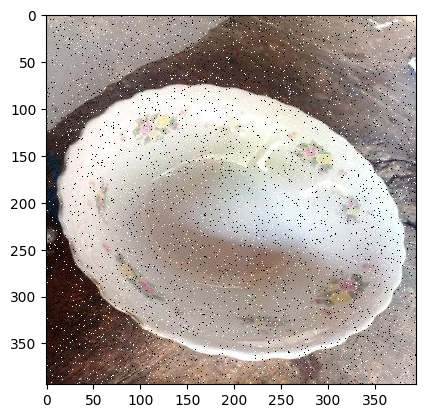

In [22]:
image = np.array(Image.open("/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/"+img['file_name']).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

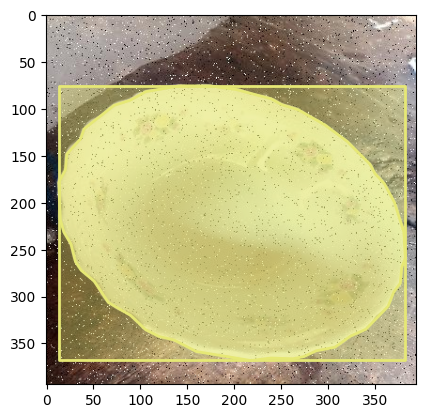

In [23]:
plt.imshow(image)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

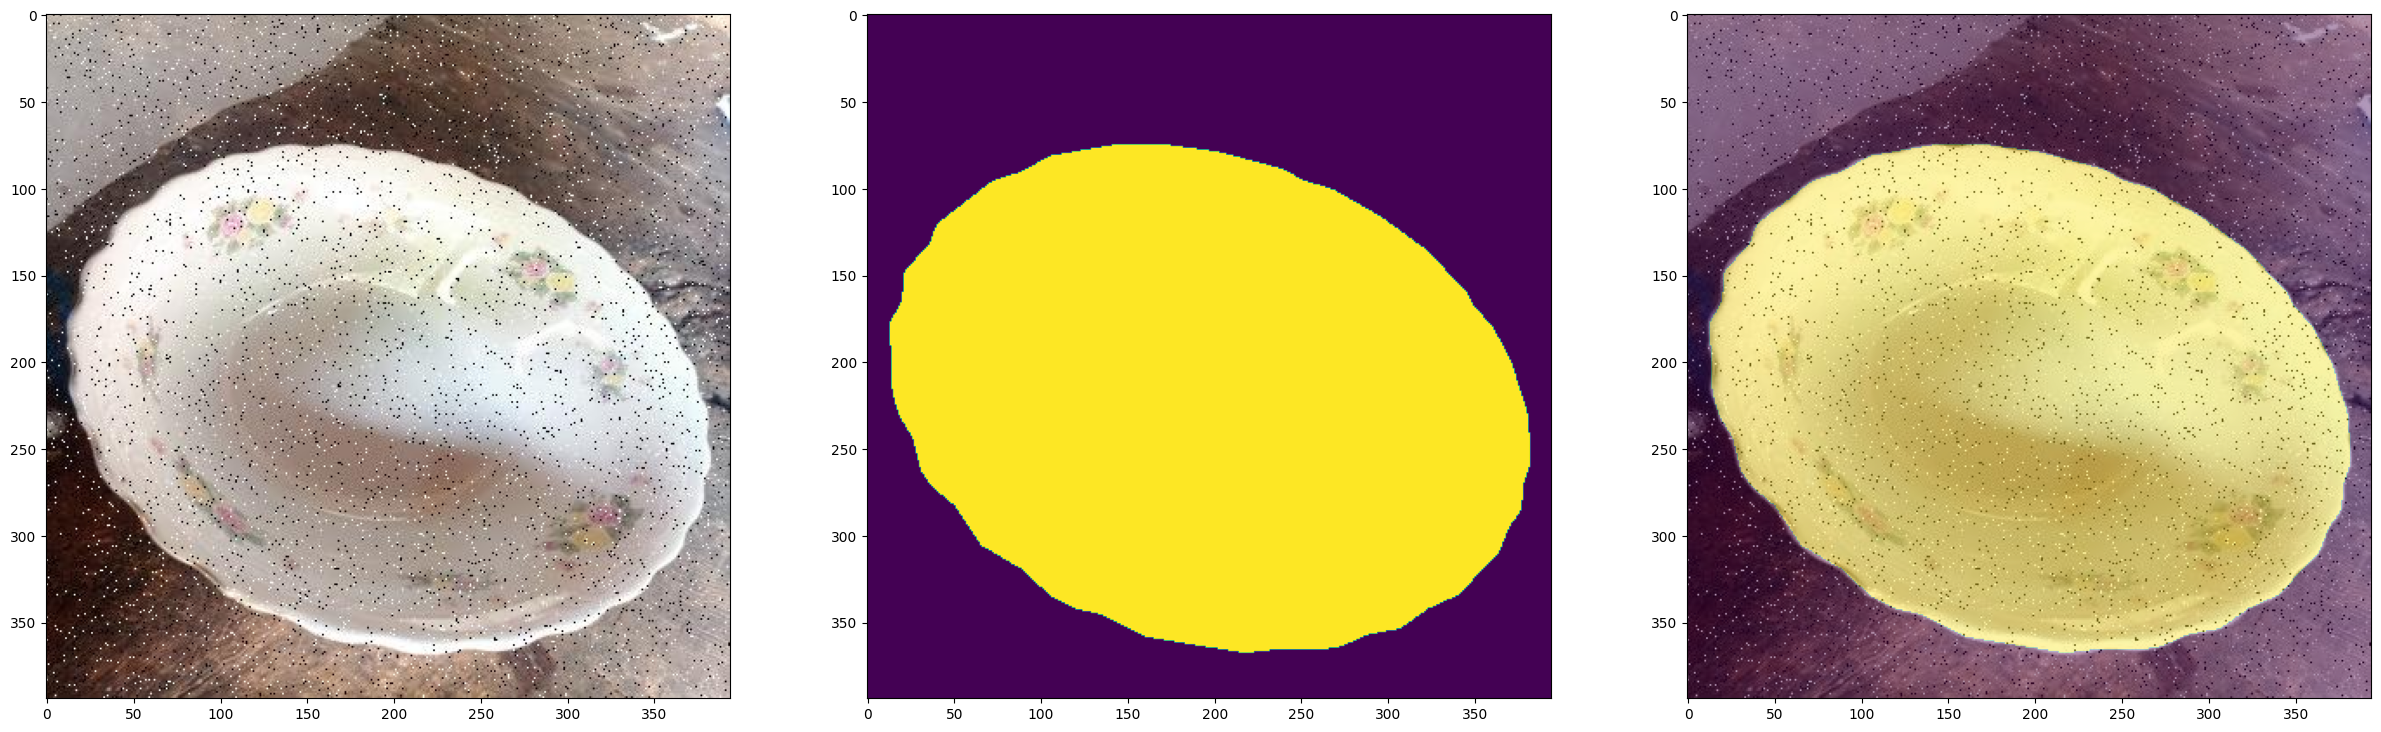

In [24]:
mask = coco_data.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(image)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [25]:
from random import sample
def loadImages(dataset_coco, split=0.1):
    img_test_ = []
    img_train_ = []
    mask_test_ = []
    mask_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    test_ids = sample([x for x in range(0,len(coco_data.anns))],int(len(coco_data.anns)*split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        categoria = coco_data.cats[1] # categoria
        label = categoria['name'] # categoria
        img_ = coco_data.imgs[image_id_]
        image_path="/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/"+img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_)/255
        anns_=dataset_coco.loadAnns(data_[i]['id'])
        mask_ = dataset_coco.annToMask(anns_[0])
        for ian in range(len(anns_)):
            mask_ += dataset_coco.annToMask(anns_[ian])
        if(i not in test_ids):
            img_train_.append(image_path)
            mask_train_.append(mask_)
            labels_train_.append(label)
        else:
            img_test_.append(image_path)
            mask_test_.append(mask_)
            labels_test_.append(label)
    return np.array(img_train_), np.array(img_test_), np.array(mask_train_), np.array(mask_test_), np.array(labels_train_), np.array(labels_test_)

In [26]:
img_train, img_test, mask_train, mask_test, labels_train ,labels_test = loadImages(coco_data, split=0.1)

In [27]:
img_train[0], img_test[0], mask_train[0].shape, mask_test[0].shape, labels_train[0].shape ,labels_test[0].shape

('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platos_sopero_94_jpg.rf.004b53979d71ec05619c3a0ec83daeb7.jpg',
 '/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platos_segundo_94_jpg.rf.06b92e608e9b5420f39b8a44cab21260.jpg',
 (394, 394),
 (394, 394),
 (),
 ())

In [28]:
import albumentations as A
from skimage import io
from skimage import color
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3, transform=None):
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        #image_load = Image.open(self.X[ix]).convert('RGB')
        img = io.imread(self.X[ix])
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        image = np.array(img) / 255
        img = image.astype(np.float32)

        mask = self.y[ix]
        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)

        if self.transform is not None:
            img = img.permute(1, 2, 0).numpy()  # Convertir de nuevo a NumPy
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            img = torch.from_numpy(img).permute(2, 0, 1)

        return img, torch.from_numpy(mask).permute(2, 0, 1)

In [30]:
trans = A.Compose([
    A.Resize(394, 394)
])
dataset = {
    'train': Dataset(img_train, mask_train, transform=trans),
    'test': Dataset(img_test, mask_test)
}

len(dataset['train']), len(dataset['test'])

(878, 97)

In [31]:
dataset['train'][0]

(tensor([[[0.5333, 0.6000, 0.5725,  ..., 0.1686, 0.1725, 0.1725],
          [0.5098, 0.5059, 0.5922,  ..., 0.1686, 0.1412, 0.1412],
          [0.4667, 0.5686, 0.6196,  ..., 0.0667, 0.1176, 0.1176],
          ...,
          [0.8549, 0.7216, 0.7412,  ..., 0.3804, 0.4078, 0.4196],
          [0.9020, 0.8353, 0.7294,  ..., 0.4000, 0.3922, 0.3922],
          [0.9176, 0.9294, 0.8000,  ..., 0.4000, 0.3765, 0.3765]],
 
         [[0.4863, 0.5529, 0.5255,  ..., 0.0980, 0.1020, 0.1020],
          [0.4627, 0.4588, 0.5451,  ..., 0.0980, 0.0706, 0.0706],
          [0.4196, 0.5216, 0.5725,  ..., 0.0000, 0.0471, 0.0471],
          ...,
          [0.2941, 0.1882, 0.2353,  ..., 0.2941, 0.3216, 0.3333],
          [0.3333, 0.2902, 0.2196,  ..., 0.3020, 0.2941, 0.2980],
          [0.3490, 0.3765, 0.2902,  ..., 0.3020, 0.2784, 0.2824]],
 
         [[0.4863, 0.5529, 0.5255,  ..., 0.0902, 0.0941, 0.0941],
          [0.4627, 0.4588, 0.5451,  ..., 0.0902, 0.0627, 0.0627],
          [0.4196, 0.5216, 0.5725,  ...,

In [33]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=16, pin_memory=True)
}
imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 394, 394]), torch.Size([16, 3, 394, 394]))

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [ ]:
#img.shape, img.dtype, img.max(), img.min()

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [34]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [ ]:
# one-hot encoding
# mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)
# mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [35]:
import torch.nn.functional as F
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [36]:
model = UNet()
output = model(torch.randn((1,3,394,394)))
output.shape

torch.Size([1, 3, 394, 394])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

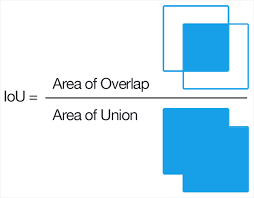

In [37]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

Ahora podemos generar predicciones para obtener máscaras de segmentación

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [38]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [39]:
model = UNet()
hist = fit(model, dataloader, epochs=5)

test_loss 0.41100 test_iou 0.42134: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]



Epoch 1/5 loss 0.55166 iou 0.35649 test_loss 0.41100 test_iou 0.42134


test_loss 0.28062 test_iou 0.92140: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]



Epoch 2/5 loss 0.37592 iou 0.75982 test_loss 0.28062 test_iou 0.92140


test_loss 0.24989 test_iou 0.91782: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]



Epoch 3/5 loss 0.30059 iou 0.90056 test_loss 0.24989 test_iou 0.91782


test_loss 0.24019 test_iou 0.91161: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]



Epoch 4/5 loss 0.25842 iou 0.90682 test_loss 0.24019 test_iou 0.91161


test_loss 0.19562 test_iou 0.93061: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


Epoch 5/5 loss 0.23313 iou 0.91421 test_loss 0.19562 test_iou 0.93061


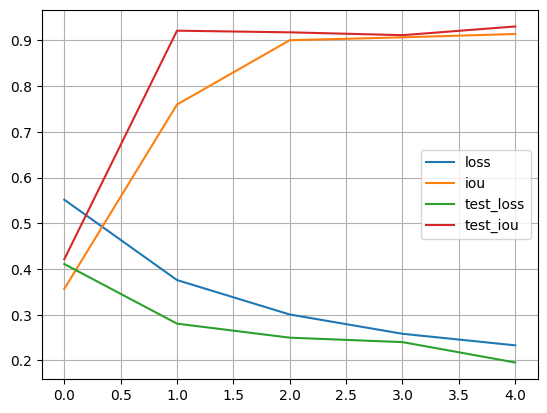

In [40]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [41]:
import torchvision

In [42]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [44]:
model = UNetResnet()
output = model(torch.randn((10,3,394,394)))
output.shape

<ipython-input-43-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([10, 3, 394, 394])

In [45]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=5)

  0%|          | 0/55 [00:00<?, ?it/s]<ipython-input-43-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.31898 test_iou 0.97123: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]



Epoch 1/5 loss 0.44956 iou 0.65389 test_loss 0.31898 test_iou 0.97123


test_loss 0.24712 test_iou 0.99014: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]



Epoch 2/5 loss 0.28693 iou 0.95240 test_loss 0.24712 test_iou 0.99014


test_loss 0.16823 test_iou 0.98962: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]



Epoch 3/5 loss 0.20564 iou 0.98499 test_loss 0.16823 test_iou 0.98962


test_loss 0.13004 test_iou 0.99343: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]



Epoch 4/5 loss 0.15049 iou 0.99127 test_loss 0.13004 test_iou 0.99343


test_loss 0.09498 test_iou 0.99211: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch 5/5 loss 0.11131 iou 0.99247 test_loss 0.09498 test_iou 0.99211


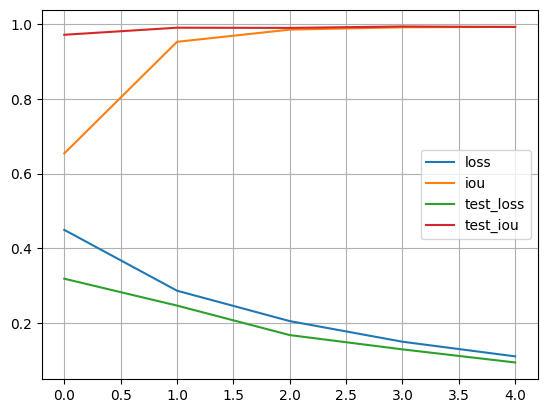

In [46]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [50]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(model.state_dict(), '/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet2_394x394.pth')

In [51]:
# Crear una instancia del modelo
modelo_cargado =UNetResnet()
# Cargar los parámetros del modelo guardado en la instancia
modelo_cargado.load_state_dict(torch.load('/content/drive/MyDrive/2parcial/Checkpoint/modelo_UNet2_394x394.pth'))

<All keys matched successfully>

In [52]:
modelo_cargado.eval()

UNetResnet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

<ipython-input-43-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


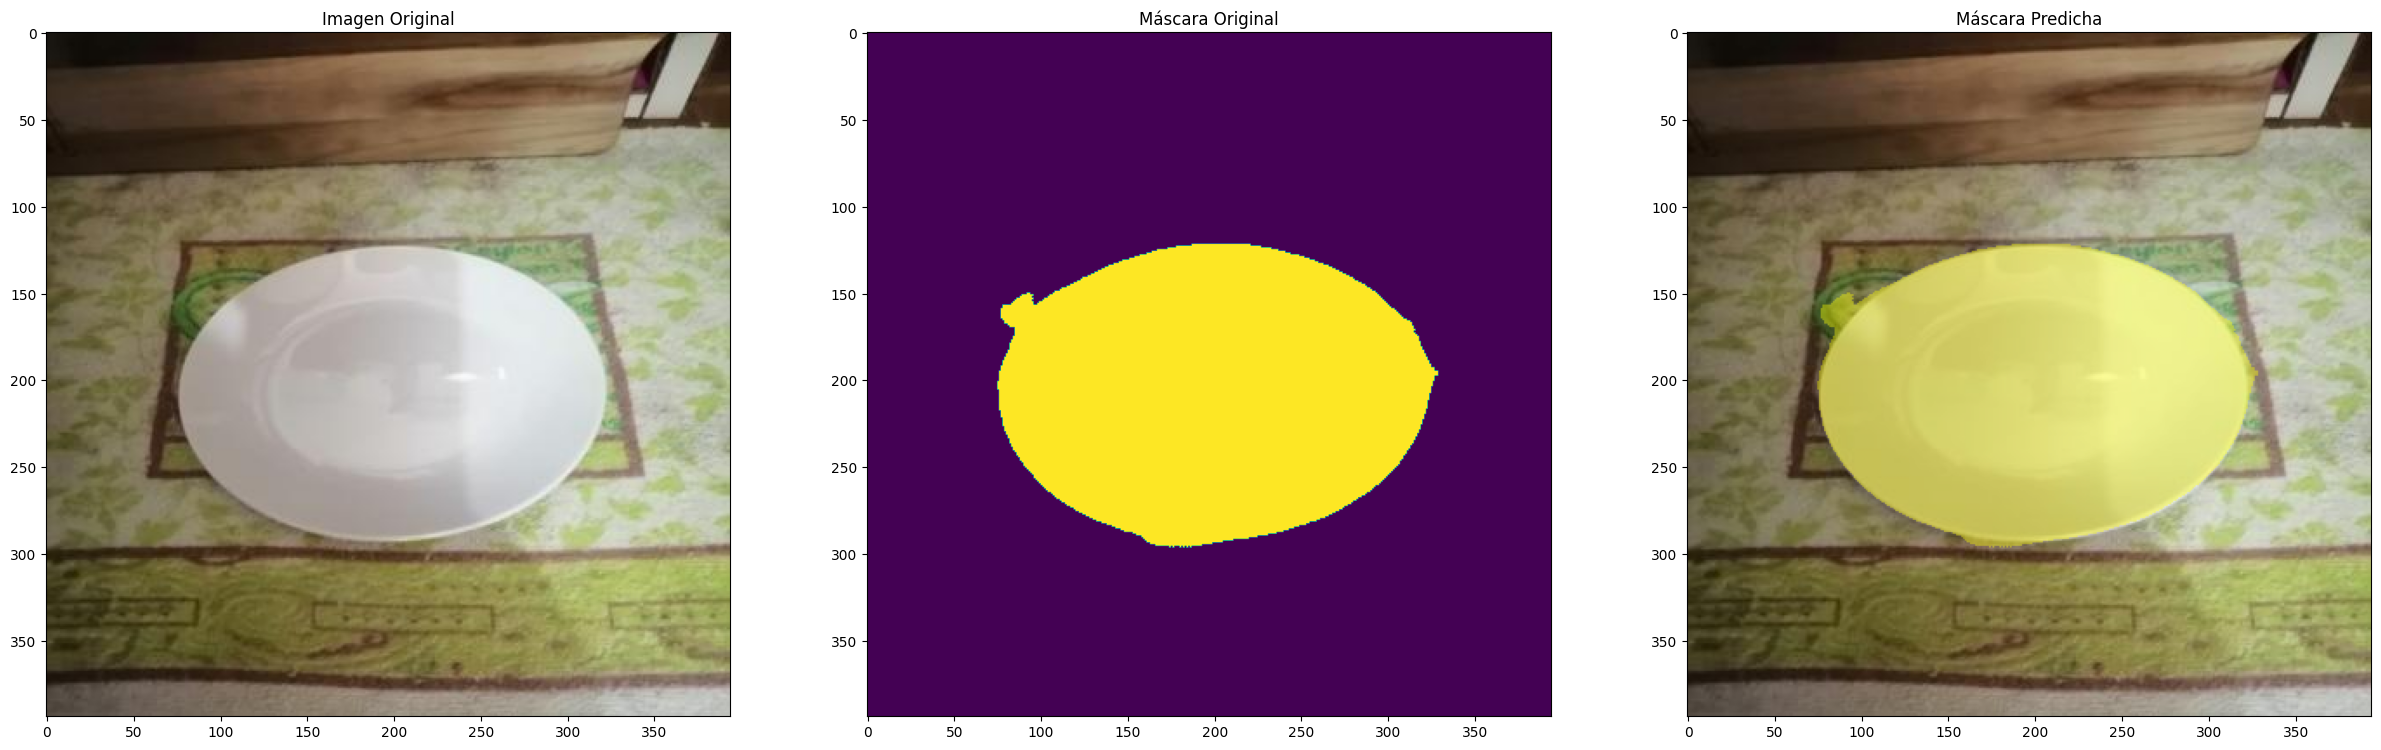

In [53]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
device = torch.device('cuda')
modelo_cargado.eval()

with torch.no_grad():
    ix = random.randint(0, len(dataset['test']) - 1)
    img, mask = dataset['test'][ix]
    img = img.unsqueeze(0).to(device)
    mask = mask.to(device)
    modelo_cargado = modelo_cargado.to(device)
    img_resized = F.interpolate(img, size=(394, 394), mode='bilinear', align_corners=False)
    output = modelo_cargado(img_resized)[0]
    pred_mask = torch.argmax(output, axis=0)
    # Redimensionar la máscara al tamaño de la imagen original (600x800)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(394, 394), mode='nearest').squeeze().cpu().numpy()
    img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convertir a NumPy array y transponer los ejes
# Configurar la transparencia de la máscara
colors = [(1, 1, 0, 0), (1, 1, 0, 0.4)]
cmap = LinearSegmentedColormap.from_list('CustomYellow', colors)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(img)
ax1.set_title('Imagen Original')

ax2.imshow(mask_resized)
ax2.set_title('Máscara Original')

ax3.imshow(img)
#ax3.imshow(mask_resized, cmap='hot', alpha=0.4)
ax3.imshow(mask_resized, cmap=cmap)
ax3.set_title('Máscara Predicha')

plt.show()


In [62]:
classes = ['background','platillos', 'platosegundo', 'platosopero']
colors = ['#1f77b4', '#008000', '#ff0000', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    modelo_cargado.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

0


<ipython-input-43-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


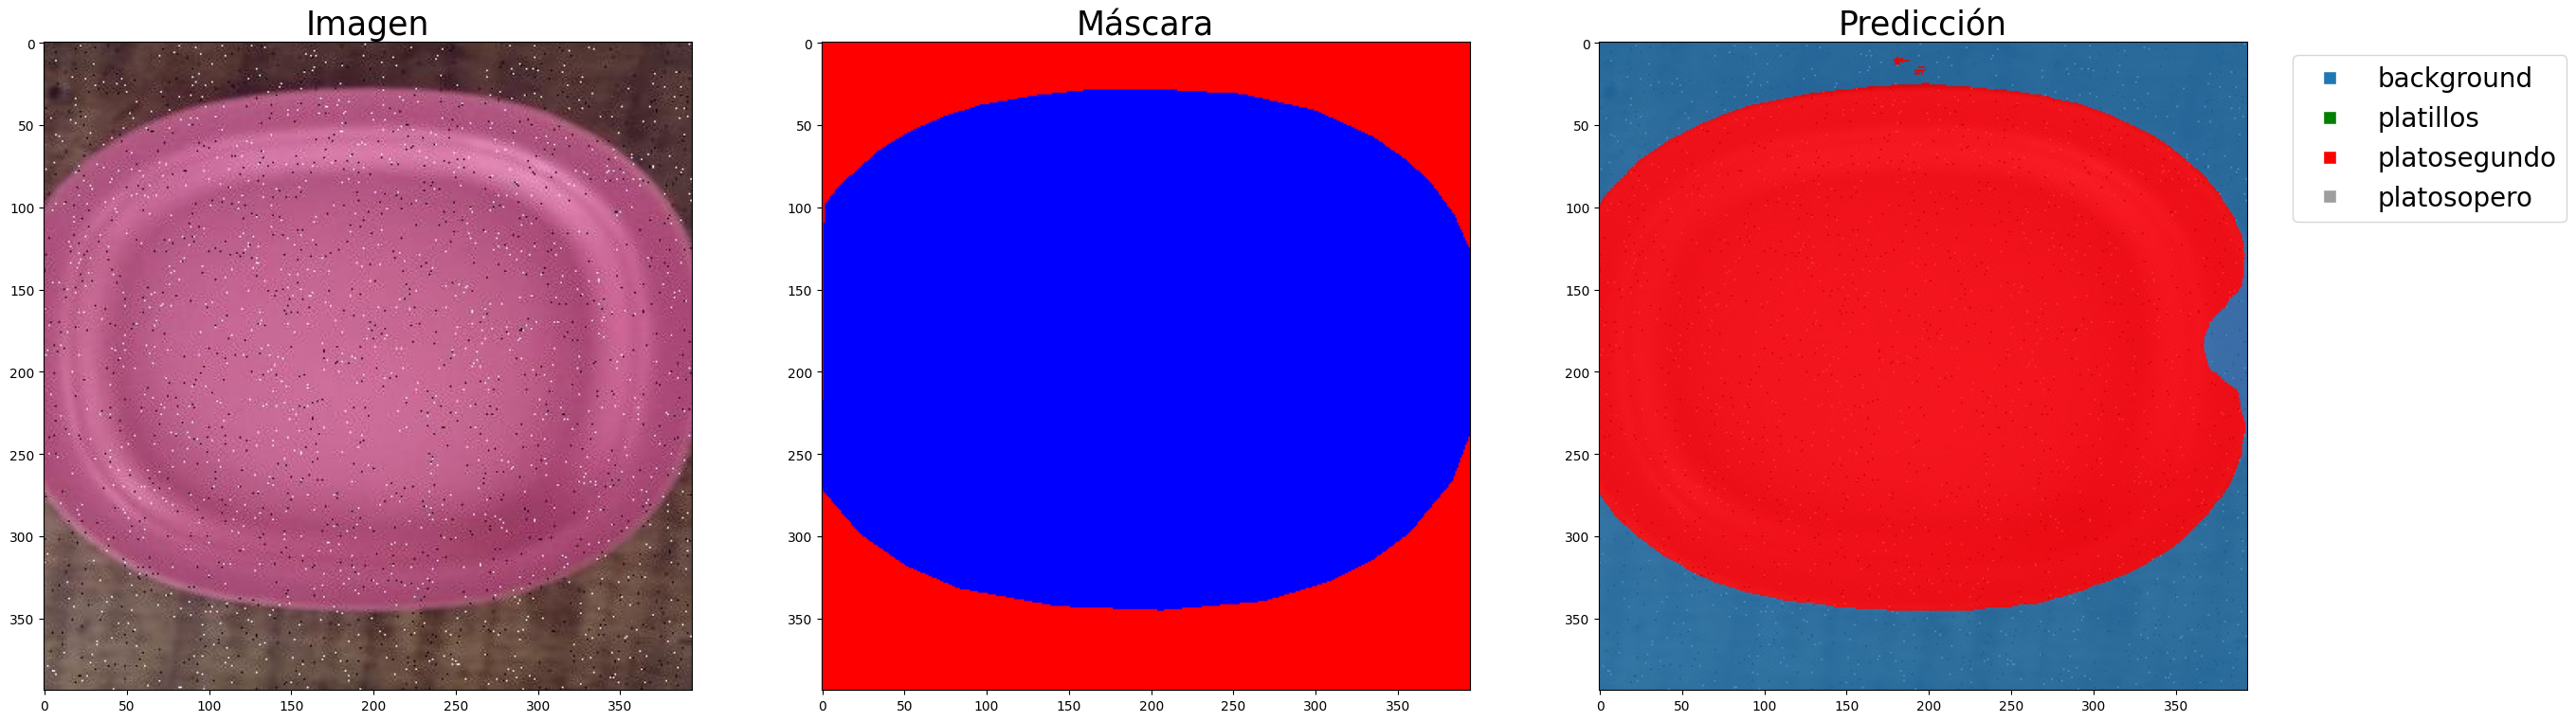

In [74]:
import random
import matplotlib.colors as mcolors
ix = random.randint(0, len(dataset['test']) - 1)
print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

In [58]:
#def visualizar_prediccion(img, mask_predicha, mask_original):
def visualizar_prediccion(img, mask_predicha):
    # Configurar la transparencia y el color de la máscara
    colors = [(1, 1, 0, 0), (1, 1, 0, 0.4)]
    cmap = LinearSegmentedColormap.from_list('CustomYellow', colors)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    ax1.imshow(img)
    ax1.set_title('Imagen Original')

    ax2.imshow(mask_predicha)
    ax2.set_title('Máscara Predicha')

    ax3.imshow(img)
    ax3.imshow(mask_predicha, cmap=cmap)
    ax3.set_title('Máscara Con la Imagen Original')

    plt.show()

<ipython-input-43-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


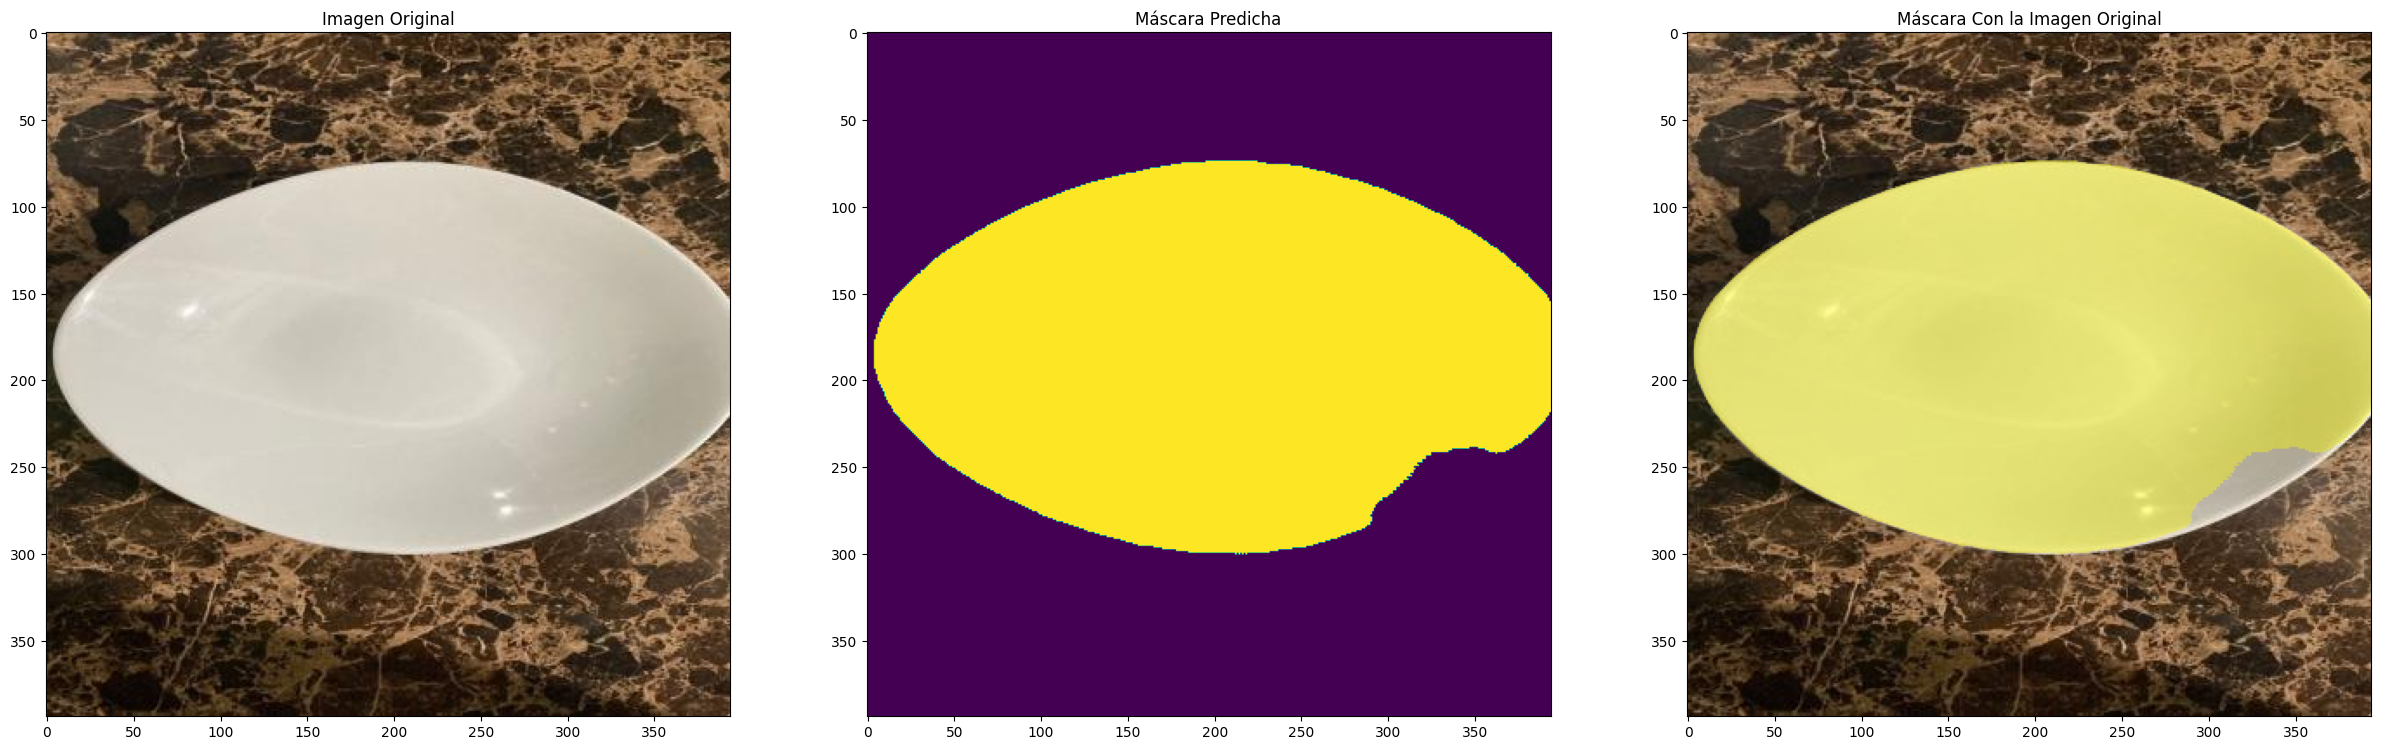

In [59]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

modelo_cargado.eval()

with torch.no_grad():
    ix = random.randint(0, len(dataset['test']) - 1)
    img, _ = dataset['test'][ix]
    img = img.unsqueeze(0).to(device)
    #mask = mask.to(device)
    modelo_cargado = modelo_cargado.to(device)
    img_resized = F.interpolate(img, size=(394, 394), mode='bilinear', align_corners=False)
    output = modelo_cargado(img_resized)[0]
    pred_mask = torch.argmax(output, axis=0)
    # Redimensionar la máscara al tamaño de la imagen original (600x800)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(394, 394), mode='nearest').squeeze().cpu().numpy()
    img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convertir a NumPy array y transponer los ejes
# Configurar la transparencia de la máscara

#visualizar_prediccion(img, mask_resized, torch.argmax(mask, axis=0).cpu().numpy())
visualizar_prediccion(img, mask_resized)

In [60]:
from PIL import Image
image_load_1 = Image.open('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/test/platos_segundo_119_jpg.rf.9815ee24fad0cea3d258d56a8f3682fb.jpg').convert('RGB')
image_1 = np.array(image_load_1) / 255
img_1 = torch.from_numpy(image_1).permute(2, 0, 1).unsqueeze(0).to(device)

<ipython-input-43-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


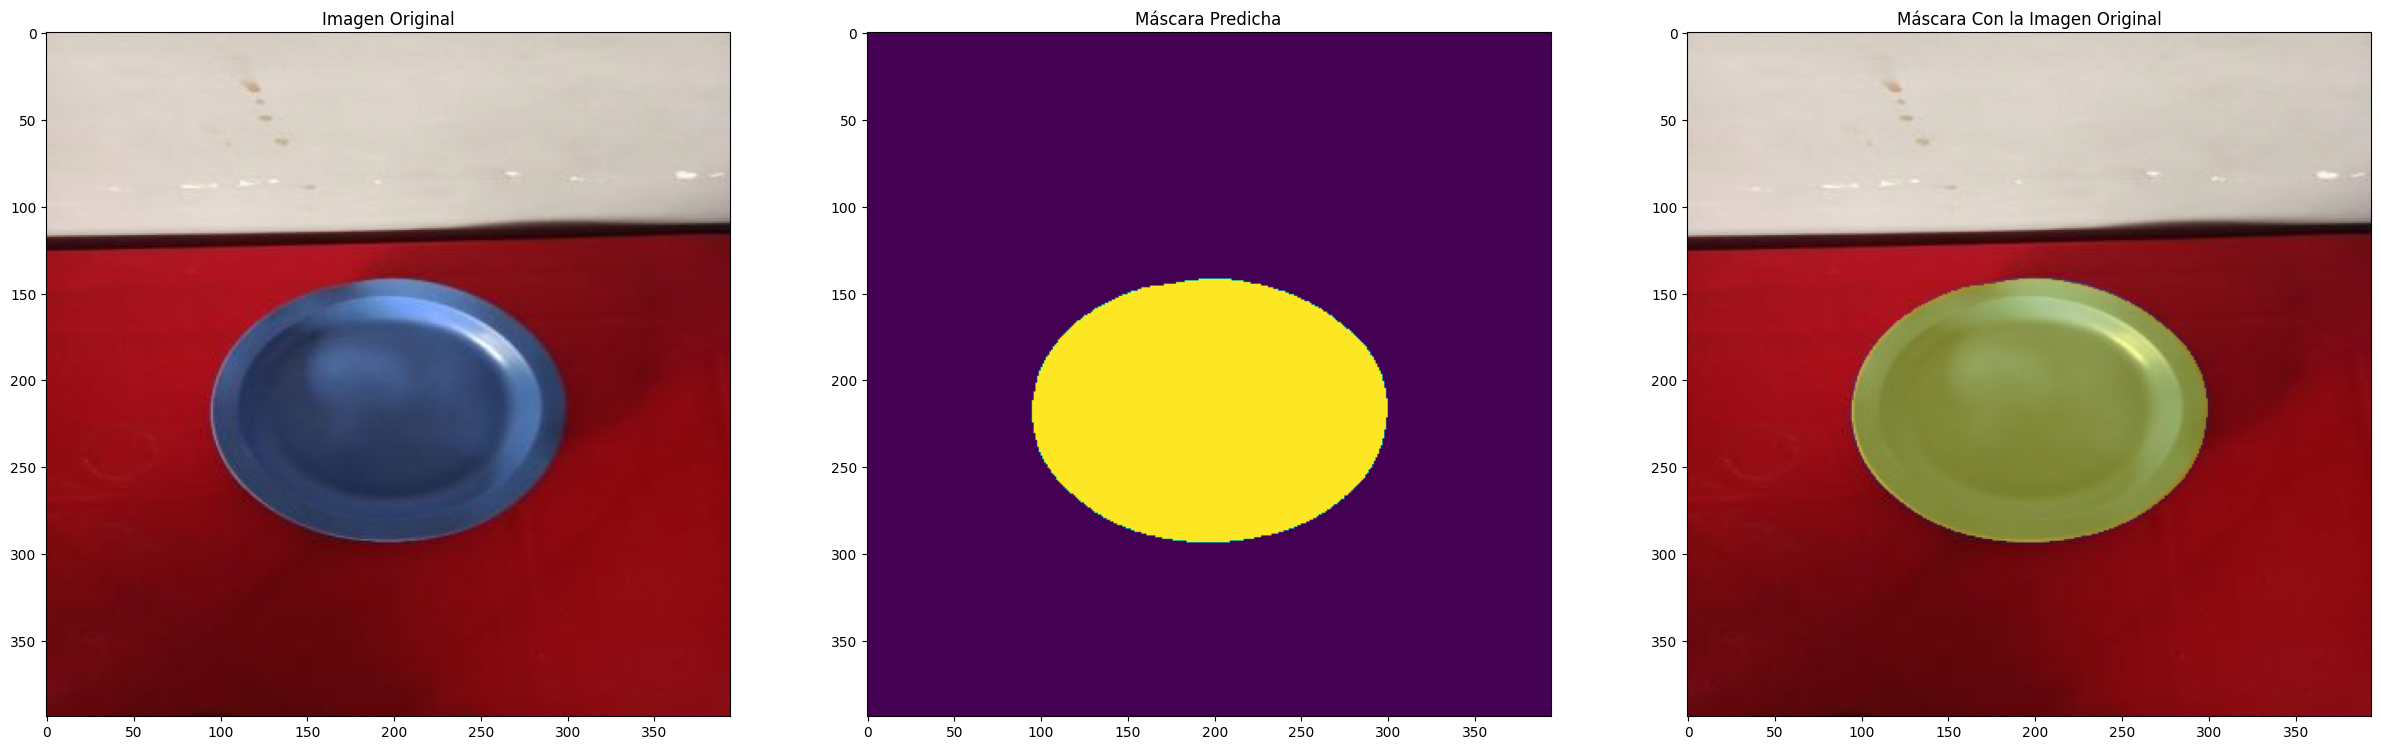

In [61]:
with torch.no_grad():
    img_resized = F.interpolate(img_1, size=(394, 394), mode='bilinear', align_corners=False)
    img_resized = img_resized.float()  # Convertir a torch.cuda.FloatTensor
    output = modelo_cargado(img_resized)[0]
    pred_mask = torch.argmax(output, axis=0)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(394, 394), mode='nearest').squeeze().cpu().numpy()
    img_1 = img_1.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    # Redimensionar la imagen a 600x800
    img_1 = Image.fromarray((img_1 * 255).astype(np.uint8))
    img_1_resized = img_1.resize((394, 394))
    img_1_resized = np.array(img_1_resized) / 255

    visualizar_prediccion(img_1_resized, mask_resized)

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.